In [1]:
import pandas as pd
from feat_eng import *

In [2]:
data = get_pollutant_data('PM2.5', 24, 72, True)

train_end = '2017-01-01 00:00:00'
val_end = '2017-02-01 00:00:00'
data_train, data_val, data_test = split_data(data, train_end, val_end)

X_train, y_train = data_train.iloc[:, :-1], data_train.iloc[:, -1]
X_val, y_val = data_val.iloc[:, :-1], data_val.iloc[:, -1]
X_test, y_test = data_test.iloc[:, :-1], data_test.iloc[:, -1]

Dates train      : 2013-03-03 23:00:00 --- 2017-01-01 00:00:00  (n=402936)
Dates validation : 2017-01-01 00:00:00 --- 2017-02-01 00:00:00  (n=8940)
Dates test       : 2017-02-01 00:00:00 --- 2017-02-28 22:00:00  (n=8052)


In [6]:
import xgboost as xgb

model = xgb.XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 5,
    random_state = 11,
    enable_categorical = True,
    device = 'cuda'
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [5]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV

param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.25],
    'subsample': [0.5, 0.75, 1]
}

tscv = TimeSeriesSplit(
    n_splits = 5,
    gap = 48
)

search = RandomizedSearchCV(
    estimator = model,
    param_distributions = param_grid,
    n_iter = 30,
    scoring = 'neg_mean_absolute_error',
    cv = tscv,
    verbose = 2,
    n_jobs = 1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END learning_rate=0.01, max_depth=5, n_estimators=250, subsample=0.5; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=250, subsample=0.5; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=250, subsample=0.5; total time=   3.1s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=250, subsample=0.5; total time=   3.8s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=250, subsample=0.5; total time=   4.8s
[CV] END learning_rate=0.25, max_depth=5, n_estimators=250, subsample=1; total time=   1.0s
[CV] END learning_rate=0.25, max_depth=5, n_estimators=250, subsample=1; total time=   1.6s
[CV] END learning_rate=0.25, max_depth=5, n_estimators=250, subsample=1; total time=   2.2s
[CV] END learning_rate=0.25, max_depth=5, n_estimators=250, subsample=1; total time=   2.7s
[CV] END learning_rate=0.25, max_depth=5, n_estimators=250, subsample=1; total time=   3.3s
[CV] END

In [20]:
search_results = pd.DataFrame(data = search.cv_results_)
search_results.sort_values(by = 'rank_test_score', axis = 0, ascending = True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
27,0.822611,0.329282,0.020707,0.000457,1.00,100,3,0.10,"{'subsample': 1, 'n_estimators': 100, 'max_dep...",-14.365517,-9.792545,-8.805060,-11.175976,-9.084153,-10.644650,2.033346,1
21,1.160139,0.449181,0.032744,0.000723,1.00,100,5,0.10,"{'subsample': 1, 'n_estimators': 100, 'max_dep...",-15.459055,-9.601257,-8.631706,-10.945505,-8.887532,-10.705011,2.509138,2
26,1.258006,0.441589,0.036282,0.005221,0.50,100,5,0.10,"{'subsample': 0.5, 'n_estimators': 100, 'max_d...",-15.932182,-9.648288,-8.624376,-10.925751,-8.903568,-10.806833,2.683695,3
22,9.852836,3.465085,0.202997,0.021790,0.75,500,7,0.01,"{'subsample': 0.75, 'n_estimators': 500, 'max_...",-16.135874,-9.592265,-8.622931,-11.060770,-8.848842,-10.852136,2.776013,4
11,1.986396,0.811048,0.039563,0.004191,0.50,250,3,0.10,"{'subsample': 0.5, 'n_estimators': 250, 'max_d...",-15.415801,-9.793600,-9.064855,-11.195101,-8.984210,-10.890713,2.397550,5


In [24]:
best_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [25]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f'Mean Absolute Error:       {mae:.3f} \n'
      f'Root Mean Squared Error:   {rmse:.3f}')

Mean Absolute Error:       9.047 
Root Mean Squared Error:   18.132


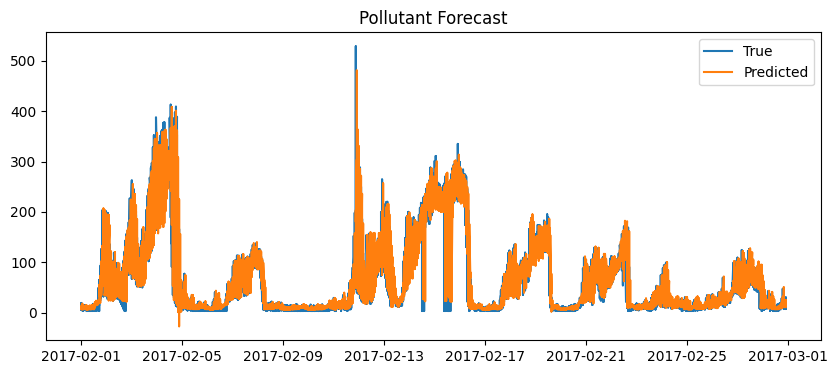

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values[:], label='True')
plt.plot(y_test.index, y_pred[:], label='Predicted')
plt.legend()
plt.title('Pollutant Forecast')
plt.show()